In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import pickle
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import math
from underthesea import word_tokenize
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('2k_data_Sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback ID      2000 non-null   float64
 1   Lookup Text      2000 non-null   object 
 2   Question Text    2000 non-null   object 
 3   Feedback Type    2000 non-null   object 
 4   Feedback Result  2000 non-null   object 
 5   Human Feedback   2000 non-null   object 
 6   Lookup Image     2000 non-null   object 
 7   Question Image   2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


In [3]:
df.head()

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image
0,4416.0,b) \( \left(\frac{-4}{15}-\frac{18}{19}\right)...,a) \( \frac{2}{3}+\frac{-1}{3}+\frac{7}{15} \)...,NEGATIVE,MATCH,NOT MATCH,https://s3.icankid.io/uploads/question/9a7aa76...,https://s3.icankid.io/uploads/question/41bf56d...
1,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...
2,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...
3,4423.0,Câu 49: Cho hàm số \( y=f(x) \) có đạo hàm là ...,Câu 49. Cho hàm số \( y=f(x) \) có đạo hàm \( ...,NEGATIVE,NOT_MATCH,NOT MATCH,https://s3.icankid.io/uploads/question/a981260...,https://s3.icankid.io/uploads/question/aaa4976...
4,4425.0,b. Giải phương trình: \( 2 \sin ^{2} x+\sqrt{3...,1) \( \sin ^{2} 2 x-(2+\sqrt{3}) \sin 2 x+\sqr...,NEGATIVE,NOT_MATCH,NOT MATCH,https://s3.icankid.io/uploads/question/caa519f...,https://s3.icankid.io/uploads/question/7ea6f5f...


In [4]:
from reportlab.pdfgen import canvas

c = canvas.Canvas("hello.pdf")
c.drawString(100,750,df['Lookup Text'][0])
c.save()

In [5]:
df['Lookup Text'][3]

'Câu 49: Cho hàm số \\( y=f(x) \\) có đạo hàm là \\( f^{\\prime}(x)=(x-1)\\left(x^{2}-4\\right)(x+10) \\), với moi \\( x \\in R \\). Có tất cả bao nhiêu giá trị nguyên của tham số \\( m \\) đề hàm số \\( g(x)=f\\left(|x|^{3}+3|x|-3 m-m^{2}\\right) \\) có đúng 7 điểm cực trị?\nA. 3 .\nB. 4 .\nC. 6\nD. 5 .'

In [6]:
from sympy.interactive import printing
printing.init_printing(use_latex = True)

import sympy as sp

In [ ]:
check if there are math formulas in latex format, if yes then convert to pdf

Đề số \\( 1 . \\)\n1. Tính\nb) \\( \\sqrt{25} \\)\nc) \\( \\sqrt{-36} \\)\na) \\( \\sqrt{64} \\)\ne) \\( \\sqrt{(-5)^{2}} \\)\nd) \\( \\sqrt{5^{2}} \\)\nf) \\( \\frac{2}{3} \\sqrt{81}-\\left(-\\frac{3}{4}\\right): \\sqrt{\\frac{9}{64}}+\\left(\\frac{\\sqrt{2}}{\\sqrt{3}}\\right)^{0}-(\\sqrt{3})^{2} \\)

In [7]:
df.duplicated().sum()

0

In [8]:
df_query = df[['Lookup Text']]
df_name = df[['Question Text']]

In [9]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
#     #replace extra spaces with single space
#     text = re.sub(' +',' ',text)
    
#     #xoá khoảng trắng ở đầu và cuối mỗi câu
#     text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [10]:
df_name['clean_question'] = df_name['Question Text'].map(lambda x: clean_function(x))
df_name

,Question Text,clean_question
0,a) \( \frac{2}{3}+\frac{-1}{3}+\frac{7}{15} \)...,a ) \ ( \_frac { 2 } { 3 }_+_\ frac { - 1 } { ...
1,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,b ) \ ( \ sqrt { 25 }_\ ) c ) \ ( \ sqrt { - 3...
2,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,đề số \ ( 3 . \ ) 1_._tính : \ ( \ sqrt {_\ fr...
3,Câu 49. Cho hàm số \( y=f(x) \) có đạo hàm \( ...,câu 49 . cho hàm_số \ ( y_=_f ( x ) \ ) có đạo...
4,1) \( \sin ^{2} 2 x-(2+\sqrt{3}) \sin 2 x+\sqr...,1 ) \ ( \ sin ^ { 2 } 2 x - ( 2 + \ sqrt { 3 }...
...,...,...
1995,"8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...","8 . vào tháng 6 , giá niêm_yết một chiếc ti vi..."
1996,"Ví dụ 3: Cho tam giác \( A B C \). Gọi \( M , ...",ví_dụ 3 : cho tam_giác \ ( a b c \ ) ._gọi \ (...
1997,Bài 8: Cho hàm số y \( =(m+4) x-m+6 \) (d)\na)...,bài 8 : cho hàm_số y_\ ( = ( m + 4 ) x-m+6 \ )...
1998,13.VN Viết các tập hợp sau bằng phương pháp li...,13.vn viết các tập_hợp sau bằng phương_pháp li...


In [11]:
df_query['clean_query'] = df_query['Lookup Text'].map(lambda x: clean_function(x))
df_query

,Lookup Text,clean_query
0,b) \( \left(\frac{-4}{15}-\frac{18}{19}\right)...,b ) \ ( \_left ( \ frac { - 4 } { 15 } - \ fra...
1,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,đề số \ ( 1_._\ ) 1_._tính b ) \ ( \ sqrt { 25...
2,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,1_._tính : \ ( \ sqrt {_\ frac { 25 }_{ 4 } }_...
3,Câu 49: Cho hàm số \( y=f(x) \) có đạo hàm là ...,câu 49 : cho hàm_số \ ( y_=_f ( x ) \ ) có đạo...
4,b. Giải phương trình: \( 2 \sin ^{2} x+\sqrt{3...,b . giải phương_trình : \ ( 2 \ sin ^ { 2 } x ...
...,...,...
1995,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","bao_nhiêu phần kế_hoạch ? 8 . vào tháng 6 , gi..."
1996,"Uai 2. Cho tam giác \( A B C \). Goi \( M, N, ...",uai 2_. cho tam_giác \ ( a b c \ ) ._goi \ ( m...
1997,Bài 23: Cho hàm số \( y=(m-1) x+m \)\n(d)\na. ...,bài 23 : cho hàm_số \ ( y_= ( m-1 ) x + m \ ) ...
1998,ç Bài 2. Viết các tập hợp sau bằng phương pháp...,ç bài 2_. viết các tập_hợp sau bằng phương_phá...


In [12]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

In [13]:
tf = TfidfVectorizer(analyzer='word', stop_words = stop_words, min_df = 0)
tf = tf.fit(df_name['clean_question'])
tf_idf_matrix = tf.transform(df_name['clean_question'])
tf_idf_matrix.shape

In [14]:
tf_idf_matrix = pd.DataFrame(tf_idf_matrix.toarray(),
                                columns = tf.get_feature_names())
tf_idf_matrix.head()

,00,000,0004,000_,001,001_,004,004_,00_,01,...,ủng_hộ,ủp,ủu,ứng,ứng_dụng,ứng_xử,ừng,ửng,ựng,一_
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
from time import time
def nearestNeighbors_search_noPCA(query, tfidf_matrix):
#     #Load data
#     product = pd.read_csv('data/product_names_clean.csv', index_col=0)

#     #Load model
#     with open('tfidf.pkl', 'rb') as file:  
#         tfidf_model = pickle.load(file)
    
    t0 = time()
    #query cleaning
    q = clean_function(query)
    
    #Vectorize query
    q_tf = tf.transform([q])
    q_tf = pd.DataFrame(q_tf.toarray(), 
                        columns=tf.get_feature_names())
    
    #Find 5 nearest neighbors
    neigh = NearestNeighbors(n_neighbors=5, metric='minkowski', algorithm = 'auto')
    neigh.fit(tfidf_matrix)    
    distance, idx = neigh.kneighbors(q_tf)
    names = df_name.loc[idx[0],'Question Text'].values
    results = pd.DataFrame([names, distance[0]], index = ['question_text', 'distance']).T
    print('Time:',time()-t0)
    return results  

In [19]:
query_search = df['Lookup Text'][3]
query_search

'Câu 49: Cho hàm số \\( y=f(x) \\) có đạo hàm là \\( f^{\\prime}(x)=(x-1)\\left(x^{2}-4\\right)(x+10) \\), với moi \\( x \\in R \\). Có tất cả bao nhiêu giá trị nguyên của tham số \\( m \\) đề hàm số \\( g(x)=f\\left(|x|^{3}+3|x|-3 m-m^{2}\\right) \\) có đúng 7 điểm cực trị?\nA. 3 .\nB. 4 .\nC. 6\nD. 5 .'

In [20]:
nearestNeighbors_search_noPCA(query_search, tf_idf_matrix)

Time: 0.1309208869934082


,question_text,distance
0,Câu 49. Cho hàm số \( y=f(x) \) có đạo hàm \( ...,0.78984
1,Câu 110: Cho hàm số \( y = f ( x ) \) có đạo h...,0.903188
2,âu 17. (THPT Ba Đình 2019) Cho hàm số \( y=f(x...,0.975864
3,LOAI 3: CHO LUÔN HÀM SO \( y=f^{\prime}(x) \)\...,0.988984
4,Có bao nhiêu giá trị nguyên của tham số \( m \...,0.998411


In [21]:
mask1 = df['Feedback Type'] == 'POSITIVE'
mask2 = df['Human Feedback'] == 'MATCH'
df_pos = df[mask1 & mask2]
df_pos.head()

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image
2,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...
7,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...
11,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...
13,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...
16,4457.0,Câu 5. Có thể lập ra được bao nhiêu số điện th...,Câu 5. Có thể lập ra được bao nhiêu số điện th...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/f59e47f...,https://s3.icankid.io/uploads/question/90c9050...


In [22]:
df_pos.tail()

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image
1986,9941.0,"Vi dụ 1. Một hộp đựng 8 viên bi xanh, 4 viên b...","Ví dụ 1. Một hộp đựng 8 viên bi xanh, 4 viên b...",POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/74db56c...,https://s3.icankid.io/uploads/question/11ccc99...
1987,9944.0,Vi dụ 6. Tính giá trị của biểu thức\na) \( |x|...,Ví dụ 6. Tính giá trị của biểu thức\na) \( |x|...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/d46c84b...,https://s3.icankid.io/uploads/question/2859c25...
1989,9955.0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a08206d...,https://s3.stag.icankids.com.vn/uploads/questi...
1994,9973.0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f60a06b...,https://s3.icankid.io/uploads/question/2740c6d...
1995,9978.0,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/9fee271...,https://s3.icankid.io/uploads/question/9363c3c...


In [153]:
nn_result = nearestNeighbors_search_noPCA(df_pos['Lookup Text'][1], tf_idf_matrix)
nn_result

KeyError: 1

In [145]:
df_pos['Lookup Image'][7]

'https://s3.icankid.io/uploads/question/71b3a3c0-29ae-11ed-8671-9785b1571c36'

In [146]:
df_pos['Question Image'][7]

'https://s3.icankid.io/uploads/question/3c3ec9e0-f876-11ec-abd5-4dcb92c2b90f'

In [147]:
df_pos['Lookup Text'][7]

'25. Tìm giá trị x (làm tròn đến chữ số thập phân thứ ba) trong mỗi tam giác vuông với kích thước được chỉ ra trên hình 10 , biết rằng :\nHinh 10'

In [148]:
df_pos['Question Text'][7]

'b) Canh BC.\n5. Tìm giá trị \\( x \\) (làm tròn đển chữ só thâp phân thú ba) trong mō̉ tam giác vuông với kích thước được chỉ ra trên hình 10 , biết rằng :'

In [61]:
pca = PCA(n_components = 10, random_state = 42)
pca = pca.fit(tf_idf_matrix)
names_pca = pca.transform(tf_idf_matrix)

In [62]:
names_pca.shape

In [63]:
PC_values = np.arange(pca.n_components_) + 1
PC_values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

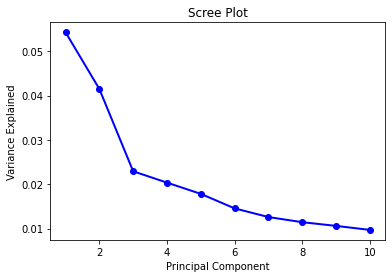

In [64]:
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [65]:
print(pca.explained_variance_ratio_)

[0.05429206 0.04148548 0.02292363 0.02037335 0.01783329 0.0145586
 0.01260522 0.01144564 0.01060983 0.00970432]


In [66]:
pca.explained_variance_ratio_.sum()

In [67]:
name_recover = pca.inverse_transform(names_pca)
name_recover

array([[-7.21610682e-06, -8.64277170e-06,  1.46352800e-05, ...,
        -5.80102797e-05,  1.29126779e-04,  7.01167522e-04],
       [-1.31528579e-05, -3.65385215e-07, -2.91351732e-05, ...,
        -2.24412436e-05,  2.24494546e-04, -6.93516867e-05],
       [-5.14727473e-05, -2.54273520e-05, -1.43549606e-05, ...,
        -7.75659590e-05,  2.18677426e-04,  1.20155896e-04],
       ...,
       [ 1.27295197e-04,  8.16206715e-05,  1.48525530e-05, ...,
         2.14687633e-04,  2.99252496e-04, -2.71998945e-05],
       [-1.81753846e-04, -1.39075204e-04, -8.48163980e-05, ...,
         8.61776832e-05,  3.34184250e-04, -2.33764760e-04],
       [ 3.72249832e-04,  1.01616051e-04,  5.75566830e-05, ...,
         1.38368000e-04,  2.58138388e-04, -1.94221093e-05]])

In [68]:
names_pca.std().mean()

In [69]:
name_recover.std().mean()

In [137]:
def cosine_search_noPCA(query, tfidf_matrix):   
#     #Load models 
#     with open('tfidf.pkl', 'rb') as file:  
#         tfidf_model = pickle.load(file)
    
#     #Load data
#     df_product = pd.read_csv('data/product_names_clean.csv', index_col=0)
    
    t0 = time()
    # Clean text
    query = clean_function(query)
    
    # Vectorize query
    query_tfidf = tf.transform([query])
    query_tfidf = pd.DataFrame(query_tfidf.toarray(), 
                               columns=tf.get_feature_names())
    
    # Calculate consine similarity
    cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()

    # Get index of top 5 similarities_score
    related_product_indices = cosine_similarities.argsort()[-5:]

    # Get top 5 similarities_score
    cosine_similarities.sort()
    similarities_score = cosine_similarities[-5:]
    result_dict = { 'question_text': df_name.iloc[related_product_indices,:]['Question Text'].values, 
                    'sim_score':similarities_score}
    result = pd.DataFrame({k: pd.Series(v) for k, v in result_dict.items()}).sort_values('sim_score', ascending = False)
    print('Time:', time()-t0)
    return result

In [142]:
df_pos.head(10)

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image
2,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...
7,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...
11,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...
13,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...
16,4457.0,Câu 5. Có thể lập ra được bao nhiêu số điện th...,Câu 5. Có thể lập ra được bao nhiêu số điện th...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/f59e47f...,https://s3.icankid.io/uploads/question/90c9050...
17,4459.0,Câu 68. Rủt gọn phân thức \( \frac{x^{2}-16 y^...,Câu 68. Rút gọn phân thức \( \frac{x^{2}-16 y^...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/b468e6e...,https://s3.icankid.io/uploads/question/57c57fe...
19,4462.0,e. \( 2 \sin ^{2} x+\sin x \cos x-\cos ^{2} x=...,12. \( 2 \sin ^{2} x+\sin x \cos x-\cos ^{2} x...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/64c6a1c...,https://s3.stag.icankids.com.vn/uploads/questi...
22,4470.0,"Ví dụ 4. Cho các số thực \( x, y \) thỏa mãn \...","Ví dụ 4. Cho các số thực \( x, y \) thỏa mãn \...",POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/d4a66e4...,https://s3.icankid.io/uploads/question/d5b98bf...
24,4474.0,"\( 0,75-\frac{2}{3}-(-0,5)= \)","\( 0,75-\frac{2}{3}-(-0,5)= \)",POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/2261f10...,https://s3.icankid.io/uploads/question/2261f10...
25,4475.0,6. Trên \( 1 cm ^{2} \) mặt lá có khoảng 30000...,6. Trên \( 1 cm ^{2} \) mặt lá có khoàng 30000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f58bd5c...,https://s3.stag.icankids.com.vn/uploads/questi...


In [176]:
df_pos['Lookup Text'].iloc[0]

'1. Tính: \\( \\sqrt{\\frac{25}{4}}+\\left(\\sqrt{\\frac{1}{2}}\\right)^{2}:\\left(\\frac{-\\sqrt{9}}{4}\\right) \\cdot \\sqrt{\\frac{16}{81}}-3^{2}-(-2)^{2} \\)'

In [177]:
cosine_search_noPCA(df_pos['Lookup Text'].iloc[8], tf_idf_matrix)

Time: 0.12987112998962402


,question_text,sim_score
4,"\( 0,75-\frac{2}{3}-(-0,5)= \)",1.000000
3,"d) \( \frac{5}{6}-x=\frac{7}{4}-0,75-3 \)",0.835399
2,"Ban Zip\n1. Tinh:\na) \( \frac{-1}{6}+0.75 \),...",0.478460
1,"c, \( \frac{1}{2}+\frac{2}{3} \cdot x=\frac{4}...",0.449604
0,1) \( 5 \frac{1}{2}-35 \%\left(\frac{5}{2} x-1...,0.438042


In [222]:
query = df_pos['Lookup Text'].iloc[0]
query

'1. Tính: \\( \\sqrt{\\frac{25}{4}}+\\left(\\sqrt{\\frac{1}{2}}\\right)^{2}:\\left(\\frac{-\\sqrt{9}}{4}\\right) \\cdot \\sqrt{\\frac{16}{81}}-3^{2}-(-2)^{2} \\)'

In [223]:
query = clean_function(query)
query_tfidf = tf.transform([query])
query_tfidf = pd.DataFrame(query_tfidf.toarray(),
                           columns = tf.get_feature_names())

In [224]:
query_tfidf

,00,000,0004,000_,001,001_,004,004_,00_,01,...,ủng_hộ,ủp,ủu,ứng,ứng_dụng,ứng_xử,ừng,ửng,ựng,一_
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [225]:
cosine_similarities = cosine_similarity(query_tfidf, tf_idf_matrix)
cosine_similarities

array([[0.56848743, 0.69112312, 0.96525714, ..., 0.        , 0.09750562,
        0.01759723]])

In [226]:
cosine_similarities = cosine_similarities.flatten()
cosine_similarities

array([0.56848743, 0.69112312, 0.96525714, ..., 0.        , 0.09750562,
       0.01759723])

In [227]:
cosine_similarities.shape

In [266]:
related_product_indices = cosine_similarities.argsort()[-5:][::-1]
# related_product_indices = sorted(related_product_indices, reverse = True)
related_product_indices

array([   2, 1510, 1787, 1886, 1743])

In [133]:
df.iloc[related_product_indices, :]['Question Text'].values

array(['Bài 3: Rút gọn biểu thức: \\( B=\\left(\\frac{x}{x+3 \\sqrt{x}}+\\frac{1}{\\sqrt{x}+3}\\right):\\left(1-\\frac{2}{\\sqrt{x}}+\\frac{6}{x+3 \\sqrt{x}}\\right) \\) với \\( x>0 \\)',
       '4\n\\[\n\\left(\\frac{\\sqrt{14}-\\sqrt{7}}{1-\\sqrt{2}}+\\frac{\\sqrt{15}-\\sqrt{5}}{1-\\sqrt{3}}\\right) \\cdot \\frac{1}{\\sqrt{7}-\\sqrt{5}}\n\\]',
       'Vói \\( x) 0 ; i \\neq 1 \\)\n\\[\nB=\\left(1+\\frac{1}{\\sqrt{x}}\\right) \\cdot\\left(\\frac{1}{\\sqrt{x}+1}+\\frac{1}{\\sqrt{x}-1}-\\frac{2}{x-1}\\right)\n\\]',
       'a) \\( A=\\left(2+\\frac{3+\\sqrt{3}}{\\sqrt{3}+1}\\right) \\cdot\\left(2-\\frac{3-\\sqrt{3}}{\\sqrt{3}-1}\\right) \\)',
       'Đề số \\( 3 . \\)\n1. Tính: \\( \\sqrt{\\frac{25}{4}}+\\left(\\sqrt{\\frac{1}{2}}\\right)^{2}:\\left(\\frac{-\\sqrt{9}}{4}\\right) \\cdot \\sqrt{\\frac{16}{81}}-3^{2}-(-2)^{2} \\)'],
      dtype=object)

In [184]:
cosine_similarities.sort()

In [185]:
cosine_similarities

array([0.        , 0.        , 0.        , ..., 0.77805238, 0.84529789,
       0.96525714])

In [131]:
similarities_score = cosine_similarities[-5:]
similarities_score

array([0.76624131, 0.76832175, 0.77805238, 0.84529789, 0.96525714])

In [136]:
result = pd.DataFrame({'question_text': df.iloc[related_product_indices, :]['Question Text'].values,
                       'Sim_score': similarities_score}).sort_values('Sim_score', ascending = False)
result

,question_text,Sim_score
4,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,0.965257
3,a) \( A=\left(2+\frac{3+\sqrt{3}}{\sqrt{3}+1}\...,0.845298
2,Vói \( x) 0 ; i \neq 1 \)\n\[\nB=\left(1+\frac...,0.778052
1,4\n\[\n\left(\frac{\sqrt{14}-\sqrt{7}}{1-\sqrt...,0.768322
0,Bài 3: Rút gọn biểu thức: \( B=\left(\frac{x}{...,0.766241


In [154]:
df_pos

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image
2,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...
7,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...
11,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...
13,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...
16,4457.0,Câu 5. Có thể lập ra được bao nhiêu số điện th...,Câu 5. Có thể lập ra được bao nhiêu số điện th...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/f59e47f...,https://s3.icankid.io/uploads/question/90c9050...
...,...,...,...,...,...,...,...,...
1986,9941.0,"Vi dụ 1. Một hộp đựng 8 viên bi xanh, 4 viên b...","Ví dụ 1. Một hộp đựng 8 viên bi xanh, 4 viên b...",POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/74db56c...,https://s3.icankid.io/uploads/question/11ccc99...
1987,9944.0,Vi dụ 6. Tính giá trị của biểu thức\na) \( |x|...,Ví dụ 6. Tính giá trị của biểu thức\na) \( |x|...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/d46c84b...,https://s3.icankid.io/uploads/question/2859c25...
1989,9955.0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a08206d...,https://s3.stag.icankids.com.vn/uploads/questi...
1994,9973.0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f60a06b...,https://s3.icankid.io/uploads/question/2740c6d...


In [164]:
queries = df_pos['Lookup Text'].values
queries[0:2]

array(['1. Tính: \\( \\sqrt{\\frac{25}{4}}+\\left(\\sqrt{\\frac{1}{2}}\\right)^{2}:\\left(\\frac{-\\sqrt{9}}{4}\\right) \\cdot \\sqrt{\\frac{16}{81}}-3^{2}-(-2)^{2} \\)',
       '25. Tìm giá trị x (làm tròn đến chữ số thập phân thứ ba) trong mỗi tam giác vuông với kích thước được chỉ ra trên hình 10 , biết rằng :\nHinh 10'],
      dtype=object)

In [173]:
np.random.seed(42)
a = np.random.randint(0, 20, 10)
a

array([ 6, 19, 14, 10,  7,  6, 18, 10, 10,  3])

In [171]:
a.sort()
a

array([ 3,  6,  6,  7, 10, 10, 10, 14, 18, 19])

In [174]:
a

array([ 6, 19, 14, 10,  7,  6, 18, 10, 10,  3])

In [175]:
a = sorted(a, reverse = True)
a

[19, 18, 14, 10, 10, 10, 7, 6, 6, 3]

In [194]:
a

[19, 18, 14, 10, 10, 10, 7, 6, 6, 3]

In [203]:
a[:5]

[19, 18, 14, 10, 10]

In [273]:
df_pos.head(3)

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image
2,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...
7,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...
11,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...


In [980]:
def cosine_noPCA(query, tfidf_matrix, check_time = True):
    t0 = time()
    query = clean_function(query)
    query_tf = tf.transform([query])
    query_tf = pd.DataFrame(query_tf.toarray(),
                            columns = tf.get_feature_names())
    
    cosine_sim = cosine_similarity(query_tf, tf_idf_matrix).flatten()
    
    related_question = cosine_sim.argsort()[-5:][::-1]
    
    cosine_sim = sorted(cosine_sim, reverse = True)
    similarities_score = cosine_sim[:5]
    
    result = pd.DataFrame({'question_text': df.iloc[related_question, :]['Question Text'].values,
                           'sim_score': similarities_score})
    if check_time:
        print('Time:', time() - t0)
    return result

In [274]:
cosine_noPCA(df_pos['Lookup Text'].iloc[2], tf_idf_matrix)

Time: 0.10216808319091797


,question_text,sim_score
0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,0.961733
1,d) \( x^{2}-x+\frac{1}{4} \),0.294012
2,"c, \( X-\frac{4}{3}=\frac{5}{7} \)",0.294012
3,"Bài 6: Tính\na, \( \frac{1}{5}+\frac{2}{5}= \)...",0.289965
4,d) \( \frac{1}{2} x+2 \frac{1}{2}=3 \frac{1}{2...,0.288121


In [951]:
def cosine_noPCA_all(queries, tfidf_matrix, check_time = True):
    t0 = time()
    results = pd.DataFrame(columns = ['lookup_text', 'question_text', 'sim_score'])
    for q in queries:
        query = clean_function(q)
        query_tf = tf.transform([query])
        query_tf = pd.DataFrame(query_tf.toarray(),
                                columns = tf.get_feature_names())
        cosine_sim = cosine_similarity(query_tf, tfidf_matrix).flatten()
        related_index = cosine_sim.argsort()[-5:][::-1]
        cosine_sim = sorted(cosine_sim, reverse = True)
        similarities_score = cosine_sim[:5]
        result = pd.DataFrame({'lookup_text': q,
                               'question_text': df.iloc[related_index, :]['Question Text'].values,
                               'sim_score': similarities_score}).head(1)
        results = pd.concat([results, result], ignore_index = True)
    if check_time:
        print('Time:', time() - t0)
    return results

In [942]:
result_all = cosine_noPCA_all(df_pos['Lookup Text'], tf_idf_matrix)

Time: 65.70485401153564


In [283]:
result_all

,lookup_text,question_text,sim_score
0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,0.965257
1,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,0.394689
2,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,0.961733
3,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,0.905801
4,Câu 5. Có thể lập ra được bao nhiêu số điện th...,Câu 5. Có thể lập ra được bao nhiêu số điện th...,0.838926
...,...,...,...
839,"Vi dụ 1. Một hộp đựng 8 viên bi xanh, 4 viên b...","Ví dụ 1. Một hộp đựng 8 viên bi xanh, 4 viên b...",0.949415
840,Vi dụ 6. Tính giá trị của biểu thức\na) \( |x|...,Ví dụ 6. Tính giá trị của biểu thức\na) \( |x|...,0.686315
841,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,0.918416
842,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,0.898465


In [287]:
def check(x, y):
    if x == y:
        return 1
    return 0

In [290]:
mask3 = result_all['question_text'] == result_all['lookup_text']

result_all[mask3]

,lookup_text,question_text,sim_score
7,"Ví dụ 4. Cho các số thực \( x, y \) thỏa mãn \...","Ví dụ 4. Cho các số thực \( x, y \) thỏa mãn \...",1.0
8,"\( 0,75-\frac{2}{3}-(-0,5)= \)","\( 0,75-\frac{2}{3}-(-0,5)= \)",1.0
11,1. \( (158- x ): 7=20 \)\n2. \( 231-(x-6)=1339...,1. \( (158- x ): 7=20 \)\n2. \( 231-(x-6)=1339...,1.0
12,Cho tam giác \( ABC \). Gọi \( D \) là trung đ...,Cho tam giác \( ABC \). Gọi \( D \) là trung đ...,1.0
13,Câu 2: Cho hàm số \( y =-2 x +4 \);\na) Vẽ đồ ...,Câu 2: Cho hàm số \( y =-2 x +4 \);\na) Vẽ đồ ...,1.0
...,...,...,...
822,101dót tan aina cúa \( 5^{2022} Pa \),101dót tan aina cúa \( 5^{2022} Pa \),1.0
823,"c) \( 0,625+\left(\frac{-2}{7}\right)+\frac{3}...","c) \( 0,625+\left(\frac{-2}{7}\right)+\frac{3}...",1.0
824,"\( (>,<, \Rightarrow) \) thich hopp.\n\( -1 \)...","\( (>,<, \Rightarrow) \) thich hopp.\n\( -1 \)...",1.0
825,17. Hinh thang \( ABCD ( AB / / CD ) \) có \( ...,17. Hinh thang \( ABCD ( AB / / CD ) \) có \( ...,1.0


In [306]:
df_check = df_pos.iloc[:, : 4]
df_check

,Feedback ID,Lookup Text,Question Text,Feedback Type
2,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE
7,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE
11,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE
13,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE
16,4457.0,Câu 5. Có thể lập ra được bao nhiêu số điện th...,Câu 5. Có thể lập ra được bao nhiêu số điện th...,POSITIVE
...,...,...,...,...
1986,9941.0,"Vi dụ 1. Một hộp đựng 8 viên bi xanh, 4 viên b...","Ví dụ 1. Một hộp đựng 8 viên bi xanh, 4 viên b...",POSITIVE
1987,9944.0,Vi dụ 6. Tính giá trị của biểu thức\na) \( |x|...,Ví dụ 6. Tính giá trị của biểu thức\na) \( |x|...,POSITIVE
1989,9955.0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,POSITIVE
1994,9973.0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,POSITIVE


In [307]:
df_check.reset_index(drop = True, inplace = True)

In [308]:
df_check

,Feedback ID,Lookup Text,Question Text,Feedback Type
0,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE
1,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE
2,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE
3,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE
4,4457.0,Câu 5. Có thể lập ra được bao nhiêu số điện th...,Câu 5. Có thể lập ra được bao nhiêu số điện th...,POSITIVE
...,...,...,...,...
839,9941.0,"Vi dụ 1. Một hộp đựng 8 viên bi xanh, 4 viên b...","Ví dụ 1. Một hộp đựng 8 viên bi xanh, 4 viên b...",POSITIVE
840,9944.0,Vi dụ 6. Tính giá trị của biểu thức\na) \( |x|...,Ví dụ 6. Tính giá trị của biểu thức\na) \( |x|...,POSITIVE
841,9955.0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,POSITIVE
842,9973.0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,POSITIVE


In [309]:
df_check['search_result'] = result_all['question_text']
df_check['score'] = result_all['sim_score']

In [310]:
df_check

,Feedback ID,Lookup Text,Question Text,Feedback Type,search_result,score
0,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,0.965257
1,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,0.394689
2,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,0.961733
3,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,0.905801
4,4457.0,Câu 5. Có thể lập ra được bao nhiêu số điện th...,Câu 5. Có thể lập ra được bao nhiêu số điện th...,POSITIVE,Câu 5. Có thể lập ra được bao nhiêu số điện th...,0.838926
...,...,...,...,...,...,...
839,9941.0,"Vi dụ 1. Một hộp đựng 8 viên bi xanh, 4 viên b...","Ví dụ 1. Một hộp đựng 8 viên bi xanh, 4 viên b...",POSITIVE,"Ví dụ 1. Một hộp đựng 8 viên bi xanh, 4 viên b...",0.949415
840,9944.0,Vi dụ 6. Tính giá trị của biểu thức\na) \( |x|...,Ví dụ 6. Tính giá trị của biểu thức\na) \( |x|...,POSITIVE,Ví dụ 6. Tính giá trị của biểu thức\na) \( |x|...,0.686315
841,9955.0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,POSITIVE,3.36. Cho biết tích của hai số tự nhiên \( n \...,0.918416
842,9973.0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,POSITIVE,6. Hai đoạn ống nước có chiều dài lần lượt là ...,0.898465


In [355]:
mask3 = df_check['Question Text'] != df_check['search_result']

checking = df_check[mask3]
checking.reset_index(drop = True, inplace = True)


In [439]:
checking.shape

In [620]:
checking.head(60)

,Feedback ID,Lookup Text,Question Text,Feedback Type,search_result,score
0,4462.0,e. \( 2 \sin ^{2} x+\sin x \cos x-\cos ^{2} x=...,12. \( 2 \sin ^{2} x+\sin x \cos x-\cos ^{2} x...,POSITIVE,b) \( ; 2 \cos ^{2} x-\sin x \cos x-2 \sin ^{2...,0.970084
1,4612.0,Câu \( 2 . \)\na) Tim tập hơp các ước cuaa 30 ...,2. a) Tìm tập hợp các ước của 30 .\nb) Tìm tập...,POSITIVE,"Câu 5 ( 0,5 điểm).\nCho \( a>0, b>0 \) và \( a...",0.278958
2,4615.0,1.4. Phát biểu mệnh đề đảo của mồi mệnh đề sau...,4. Phát biều mệnh đề đảo của mởi mệnh đề sau v...,POSITIVE,1.4. Phát biểu mệnh đề đảo của mỗi mệnh đề sau...,0.618911
3,4674.0,\( 2 x-2^{0}=3^{5}: 3^{3} \),f) \( 2 x-2^{0}=3^{5}: 3^{3} \),POSITIVE,VAN DÊ II. Phurong phíp nhóm ahiĉ̉u hang tư\nB...,0.0
4,4970.0,BAI TAPP\n1.1. Cho hai tập hợp:\n\[\nA =\{a ; ...,1.1. Cho hai tập họp:\n\[\nA =\{a ; b ; c ; x ...,POSITIVE,1.1. Cho hai tập hợp:\n\[\nA =\{a ; b ; c ; x ...,0.753993
5,4979.0,Bài 4: (2 điểm) Giải các phương trìn!\na) \( \...,Bài 4: (2 điểm) Giải các phương trình sau:\na)...,POSITIVE,Bài 3: Giải các phương rình sau:\na) \( \sqrt{...,0.735196
6,5099.0,a) \( x^{2}\left(5 x^{3}-x-\frac{1}{2}\right) \),1. Làm tính nhân :\na) \( x^{2}\left(5 x^{3}-x...,POSITIVE,a) Tính: \( \left(\frac{-1}{2}\right)^{5} ;\le...,0.979729
7,5135.0,"1.2. Cho tập hợp\nTrong các số 3; 5; 6; 0;7, s...",1.2. Cho tập họp \( U=\{x \in N \mid x \) chia...,POSITIVE,1.2. Cho tập hợp \( U=\{x \in N \mid x \) chia...,0.350166
8,5136.0,\( \sqrt{x+2-3 \sqrt{2 x-5}}+\sqrt{x-2+\sqrt{2...,d)\n\[\n\sqrt{x+2+3 \sqrt{2 x-5}}+\sqrt{x-2-\s...,POSITIVE,Bài 9: Tính\na) \( (\sqrt{5})^{2} \)\nb) \( (\...,0.964544
9,5195.0,Chứng minh rằng phương trình \( x^{5}-3 x^{4}+...,Chứng minh răng phương trình \( x^{5}-3 x^{4}+...,POSITIVE,Cho phương trình\n\[\n(m+2) x^{2}+(2 m+1) x+2=...,0.612694


In [733]:
checking.tail(24)

,Feedback ID,Lookup Text,Question Text,Feedback Type,search_result,score
60,8153.0,1.37. Hoàn thành bảng sau vào vỏ:\n\begin{tabu...,1.37. Hoàn thành bảng sau vào vở:\n\begin{tabu...,POSITIVE,1.37. Hoàn thành bảng sau vào vở:\n\begin{tabu...,0.726254
61,8157.0,"Bài 6. Cho tam giác \( A B C \), có \( A B=8, ...","Câu 9. Cho tam giác \( A B C \), có \( A B=8, ...",POSITIVE,1. Tính độ dài cạnh \( x \) trong các tam giác...,0.509102
62,8174.0,Bài 6: Một hình chữ nhật có chiều dài \( \frac...,Bài 4: Một hình chữ nhật có chiều dài \( \frac...,POSITIVE,Bài 1. Tính chu vi và diện tích hình chữ nhật ...,0.893416
63,8177.0,Bài 6: Một hình chữ nhật có chiều dài \( \frac...,Bài 4: Một hình chữ nhật có chiều dài \( \frac...,POSITIVE,Bài 1. Tính chu vi và diện tích hình chữ nhật ...,0.893416
64,8188.0,Bài 5: Một hình chữ nhật có chu vi là \( 8 m \...,Bài 5: Một mảnh đất hình chữ nhật có chu vi là...,POSITIVE,Bài 1. Tính chu vi và diện tích hình chữ nhật ...,0.913728
65,8293.0,BÀI TẠP\nb) \( \left(x^{3}-2 x^{2}+x-1\right)(...,b) \( \left(x^{3}-2 x^{2}+x-1\right)(5-x) \).,POSITIVE,BÀ TẠP\n1. Làm tính nhân :\na) \( x^{2}\left(5...,0.626787
66,8421.0,Cho đường tròn tâm \( O \). Lấy điểm \( A \) ở...,"Câu IV \( (3,0 \) diem\nCho đưòng tròn \( ( O ...",POSITIVE,Bài 2: Cho điểm \( A \) nằm ngoài đường tròn t...,0.541105
67,8681.0,4. \( (h .7) \),4. \( (h .7) \),POSITIVE,VAN DÊ II. Phurong phíp nhóm ahiĉ̉u hang tư\nB...,0.0
68,8721.0,10) \( \sin 2 x-\cos 2 x+3 \sin x-\cos x-1=0 \),\( 8 \sin 2 x-\cos 2 x+3 \sin x-\cos x-1=0 \),POSITIVE,b) \( ; 2 \cos ^{2} x-\sin x \cos x-2 \sin ^{2...,0.910552
69,8846.0,"16. Viết tập hợp các số tự nhiên có ba chữ số,...","16. Viết tập hợp các số tự nhiên có ba chữ số,...",POSITIVE,Bài 1 Viết tập hợp các số tự nhiên có 3 chữ số...,0.970285


In [357]:
# false_pos = []

In [926]:
index_ = 3

In [927]:
checking.iloc[index_]['Lookup Text']

'\\( 2 x-2^{0}=3^{5}: 3^{3} \\)'

In [928]:
checking.iloc[index_]['Question Text']

'f) \\( 2 x-2^{0}=3^{5}: 3^{3} \\)'

In [929]:
ss = checking.iloc[index_]['search_result']
ss

'VAN DÊ II. Phurong phíp nhóm ahiĉ̉u hang tư\nBải 1. Phãn tich cac đa thức sau thânh nhân tur.\na) \\( x^{3}-2 x^{2}+2 x-13 \\)\nb) \\( x^{2} y+x y+x+1 \\)\nc) \\( a x+b y+a y+b x \\)\nd) \\( x^{3}-(a+b) x+a b \\)\ne) \\( x^{2} y+x y^{2}-x-y \\)\nf) \\( a x^{2}+a y-b x^{2}-b y \\)'

In [950]:
df_result = cosine_noPCA(checking.iloc[index_]['Lookup Text'], tf_idf_matrix)
df_result

Time: 0.08982491493225098


,question_text,sim_score
0,VAN DÊ II. Phurong phíp nhóm ahiĉ̉u hang tư\nB...,0.0
1,ÔN TẬP CHUNG\n*Bàitập\nBail: Tính:\n\( \begin{...,0.0
2,2. Đọc và viết:\na) Số tự nhiên lớn nhất có sá...,0.0
3,Bài 7) ÔN TÂP: PHÉP CÔNG VÀ PHÉP TRỨ HAI PHÂN ...,0.0
4,13) \( 2 \frac{2}{3}-1 \frac{2}{5}+1 \frac{3}{...,0.0


In [931]:
print(checking.iloc[index_]['Lookup Text'] in df_result['question_text'].values)
print(checking.iloc[index_]['Question Text'] in df_result['question_text'].values)

False
False


In [919]:
if false_pos[-1] != index_:
    false_pos.append(index_)
print(false_pos)
print(len(false_pos))

[3, 5, 6, 8, 9, 10, 11, 13, 12, 14, 16, 19, 21, 26, 25, 28, 29, 32, 37, 41, 42, 44, 45, 47, 48, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
54


In [920]:
checking

,Feedback ID,Lookup Text,Question Text,Feedback Type,search_result,score
0,4462.0,e. \( 2 \sin ^{2} x+\sin x \cos x-\cos ^{2} x=...,12. \( 2 \sin ^{2} x+\sin x \cos x-\cos ^{2} x...,POSITIVE,b) \( ; 2 \cos ^{2} x-\sin x \cos x-2 \sin ^{2...,0.970084
1,4612.0,Câu \( 2 . \)\na) Tim tập hơp các ước cuaa 30 ...,2. a) Tìm tập hợp các ước của 30 .\nb) Tìm tập...,POSITIVE,"Câu 5 ( 0,5 điểm).\nCho \( a>0, b>0 \) và \( a...",0.278958
2,4615.0,1.4. Phát biểu mệnh đề đảo của mồi mệnh đề sau...,4. Phát biều mệnh đề đảo của mởi mệnh đề sau v...,POSITIVE,1.4. Phát biểu mệnh đề đảo của mỗi mệnh đề sau...,0.618911
3,4674.0,\( 2 x-2^{0}=3^{5}: 3^{3} \),f) \( 2 x-2^{0}=3^{5}: 3^{3} \),POSITIVE,VAN DÊ II. Phurong phíp nhóm ahiĉ̉u hang tư\nB...,0.0
4,4970.0,BAI TAPP\n1.1. Cho hai tập hợp:\n\[\nA =\{a ; ...,1.1. Cho hai tập họp:\n\[\nA =\{a ; b ; c ; x ...,POSITIVE,1.1. Cho hai tập hợp:\n\[\nA =\{a ; b ; c ; x ...,0.753993
...,...,...,...,...,...,...
79,9746.0,Bài 1: Cho biếu thức \( M =\frac{1}{\sqrt{x}-2...,Bài 4: Cho biều thức \( M =\frac{1}{\sqrt{x}-2...,POSITIVE,\( \frac{a+4 \sqrt{a}+4}{\sqrt{a}+2}+\frac{4-a...,0.446821
80,9760.0,11) \( \sqrt{3} \cos 5 x-2 \sin 3 x \cos 2 x-\...,15) \( \sqrt{3} \cos 5 x-2 \sin 3 x \cdot \cos...,POSITIVE,1) a) \( \cot \left(3 x-\frac{\pi}{5}\right)+\...,0.924844
81,9823.0,Câu 7: Điểm cực tiểu của hàm số \( y=\frac{1}{...,Câu 4: Điểm cực đại của hàm số \( y=\frac{1}{3...,POSITIVE,Câu 10. Cho hàm số \( y=\frac{1}{3} x^{3}-m x^...,0.682776
82,9889.0,\( 4^{3}: 2^{5}+3^{5}: 9^{2} \),b) \( 4^{3}: 2^{5}+3^{5}: 9^{2} \),POSITIVE,VAN DÊ II. Phurong phíp nhóm ahiĉ̉u hang tư\nB...,0.0


In [993]:
def check_wrong_results(indices):
    no_results = []
    top5_results = []
    for index_ in indices:
        df_results = cosine_noPCA(checking.iloc[index_]['Lookup Text'], tf_idf_matrix, 5, check_time = False)
        top_results = df_results['question_text'].values
        if checking.iloc[index_]['Lookup Text'] in top_results or checking.iloc[index_]['Question Text'] in top_results:
            top5_results.append(index_)
        else:
            no_results.append(index_)
    return no_results, top5_results

In [994]:
no_result, top5_result = check_wrong_results(false_pos)

In [995]:
len(no_result)

In [996]:
len(top5_result)

In [997]:
after_check = checking.iloc[no_result, :].reset_index(drop = True)
after_check

,Feedback ID,Lookup Text,Question Text,Feedback Type,search_result,score
0,4674.0,\( 2 x-2^{0}=3^{5}: 3^{3} \),f) \( 2 x-2^{0}=3^{5}: 3^{3} \),POSITIVE,VAN DÊ II. Phurong phíp nhóm ahiĉ̉u hang tư\nB...,0.0
1,5099.0,a) \( x^{2}\left(5 x^{3}-x-\frac{1}{2}\right) \),1. Làm tính nhân :\na) \( x^{2}\left(5 x^{3}-x...,POSITIVE,a) Tính: \( \left(\frac{-1}{2}\right)^{5} ;\le...,0.979729
2,5136.0,\( \sqrt{x+2-3 \sqrt{2 x-5}}+\sqrt{x-2+\sqrt{2...,d)\n\[\n\sqrt{x+2+3 \sqrt{2 x-5}}+\sqrt{x-2-\s...,POSITIVE,Bài 9: Tính\na) \( (\sqrt{5})^{2} \)\nb) \( (\...,0.964544
3,5220.0,Bài 35. Cho biểu thức:\na) Rút gọn A nếu \( x ...,Bài 2. Cho biểu thức: \( A=\left(\frac{\sqrt{x...,POSITIVE,Bài 6. Cho biểu thức:\n\[\nA=\left(\frac{\sqrt...,0.785571
4,5710.0,"1.4. Baing cach nêu dáu hêu dác trung, hay vié...","1.4. Bằng cách nêu dấu hiệu đặc trưng, hãy viế...",POSITIVE,- Viét hai só́ trong đó có môt só không chia h...,0.162567
5,5991.0,Hãy tính \( x \) và y trong môi hình sau :\n(h...,Hãy tính \( x \) và \( y \) trong mổi hình sau...,POSITIVE,(4) 8 hocac i2hain thaic\n\[\n\begin{array}{ll...,0.355571
6,6137.0,"Thực hành 1: Tính:\na) \( 0,6+\left(\frac{3}{-...","Thức hành 1: Tính:\na) \( 0,6+\left(\frac{3}{-...",POSITIVE,a) Tính: \( \left(\frac{-1}{2}\right)^{5} ;\le...,0.766044
7,6199.0,"Bài 3. (3,0 điêm) Cho tam giác \( A B C \) vuô...","Bài 3. (3,0 điểm) Cho tam giác \( A B C \) vuô...",POSITIVE,Bài 4: Cho \( \triangle ABC \) vuông tại \( A ...,0.523355
8,6562.0,10. Thue hien phep tính:\na) \( \left(x^{2}-2 ...,10. Thực hiện phép tính :\na) \( \left(x^{2}-2...,POSITIVE,Bài 10 .Viết các biều thức sau dưới dạng tổng\...,0.504442
9,6701.0,\( \Rightarrow(x+3)^{2}-x(x-5)-6 x+7 \),c) \( (x+3)^{2}-x(x-5)-6 x+7 \),POSITIVE,2.86. Tìm các giới hạn sau :\na) \( \lim _{x \...,0.548136


In [981]:
def cosine_noPCA(query, tfidf_matrix, top_result, check_time = True):
    t0 = time()
    query = clean_function(query)
    query_tf = tf.transform([query])
    query_tf = pd.DataFrame(query_tf.toarray(),
                            columns = tf.get_feature_names())
    
    cosine_sim = cosine_similarity(query_tf, tf_idf_matrix).flatten()
    
    related_question = cosine_sim.argsort()[-top_result:][::-1]
    
    cosine_sim = sorted(cosine_sim, reverse = True)
    similarities_score = cosine_sim[:top_result]
    
    result = pd.DataFrame({'question_text': df.iloc[related_question, :]['Question Text'].values,
                           'sim_score': similarities_score})
    if check_time:
        print('Time:', time() - t0)
    return result

In [983]:
cosine_noPCA(after_check.iloc[5]['Lookup Text'], tf_idf_matrix, top_result = 10)

Time: 0.08296585083007812


,question_text,sim_score
0,(4) 8 hocac i2hain thaic\n\[\n\begin{array}{ll...,0.355571
1,2. Quan sát hai hinh lăng trụ đứng trong Hình ...,0.246527
2,Bài 5: Cho hình sau\na) Chứng minh \( \triangl...,0.242015
3,"4. Dựa vào cách vẽ các tam giác đã học, hãy vẽ...",0.230122
4,là hình gì? Chứng minh.\nCho \( \triangle A B ...,0.217559
5,Vận dụng \( x \)\nHãy tìm một số hình ảnh có d...,0.213821
6,Hãy tính \( x \) và \( y \) trong mổi hình sau...,0.195086
7,"3.1. Cho Hình 3.13, hãy kể tên các cặp góc kề bù.",0.183098
8,"3.1. Cho Hình 3.13, hãy kể tên các cặp góc kề bù.",0.183098
9,"3. a) Các điểm \( A , B , C \) trong Hình 8 bi...",0.182414


In [975]:
after_check['Lookup Text'].duplicated().sum()

1

In [976]:
844-23-31

In [977]:
(844-23)/844 * 100

In [900]:
clean_function(checking.iloc[index_]['Lookup Text'])

'câu 7 : điểm cực_tiểu của hàm_số \\ ( y_=_\\ frac { 1 } { 3_} x ^_{ 3 } - 2 x ^ { 2 } + 3 x + 1 \\ ) là a ._\\ ( x = - 1 \\ ) b ._\\ ( x = 1 \\ ) c ._\\ ( x = 3_\\ ) d ._\\ ( x = 0_\\ )'

In [901]:
df.loc[df['Question Text'] == ss]

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image
702,6341.0,A. \( (0 ; 2) \).\nB. \( (-\infty ; 0) \cup(2 ...,Câu 10. Cho hàm số \( y=\frac{1}{3} x^{3}-m x^...,NEGATIVE,MATCH,NOT MATCH,https://s3.icankid.io/uploads/question/53e5074...,https://s3.icankid.io/uploads/question/55ef563...


In [902]:
id_ = df.loc[df['Question Text'] == ss]['Feedback ID'].values[0]
df.loc[df['Feedback ID'] == id_]['Question Image'].values[0]

'https://s3.icankid.io/uploads/question/55ef5630-3367-11ed-afcb-abad28552b30'

In [903]:
df.loc[df['Lookup Text'] == checking.iloc[index_]['Lookup Text']]

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image
1946,9823.0,Câu 7: Điểm cực tiểu của hàm số \( y=\frac{1}{...,Câu 4: Điểm cực đại của hàm số \( y=\frac{1}{3...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/3e14f2a...,https://s3.icankid.io/uploads/question/a7489c3...


In [904]:
df.loc[df['Lookup Text'] == checking.iloc[index_]['Lookup Text']]['Lookup Image'].values[0]

'https://s3.icankid.io/uploads/question/3e14f2a0-3a23-11ed-afcb-abad28552b30'

In [905]:
df.loc[df['Lookup Text'] == checking.iloc[index_]['Lookup Text']]['Question Image'].values[0]

'https://s3.icankid.io/uploads/question/a7489c30-34fc-11ed-afcb-abad28552b30'

In [438]:
df.iloc[286, :]

Feedback ID                                                   5220.0
Lookup Text        Bài 35. Cho biểu thức:\na) Rút gọn A nếu \( x ...
Question Text      Bài 2. Cho biểu thức: \( A=\left(\frac{\sqrt{x...
Feedback Type                                               POSITIVE
Feedback Result                                                MATCH
Human Feedback                                                 MATCH
Lookup Image       https://s3.icankid.io/uploads/question/58d8520...
Question Image     https://s3.icankid.io/uploads/question/470a029...
Name: 286, dtype: object

In [368]:
fb_id = 4674.0

In [367]:
df_pos.loc[df_pos['Feedback ID'] == fb_id]['Lookup Image'].values[0]

'https://s3.icankid.io/uploads/question/90ea4e00-2c25-11ed-8671-9785b1571c36'

In [337]:
df.loc[df['Feedback ID'] == fb_id]['Question Image'].values[0]

'https://s3.icankid.io/uploads/question/3be66f00-e612-11ec-80fa-7dd59c10bdcf'

In [369]:
df.loc[df['Feedback ID'] == fb_id]

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image
99,4674.0,\( 2 x-2^{0}=3^{5}: 3^{3} \),f) \( 2 x-2^{0}=3^{5}: 3^{3} \),POSITIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/90ea4e0...,https://s3.icankid.io/uploads/question/91a64b0...


In [352]:
demo = checking.loc[checking['Feedback ID'] == fb_id]['search_result'].values[0]
demo

'1.2. Cho tập hợp \\( U=\\{x \\in N \\mid x \\) chia hết cho 3\\( \\} \\).\nTrong các số \\( 3 ; 5 ; 6 ; 0 ; 7 \\), số nào thuộc và số nào không thuộc tập U?'